# DBSCAN – Wine Quality (Vin rouge)

Ce notebook applique **DBSCAN** selon le cahier des charges :
- Détecter des groupes naturels
- Détecter des vins atypiques (outliers)
- Sensible aux paramètres `eps` et `min_samples`
- Évaluer avec silhouette score
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Trouver la racine du projet (dossier contenant src/preprocessing.py)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project (File > Open Folder) puis relancez.")
from preprocessing import load_data, clean_data, scale_features
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import mlflow
import mlflow.sklearn

mlflow.set_experiment("wine-quality-dbscan")

2026/02/14 17:34:50 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 17:34:50 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 17:34:50 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 17:34:50 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 17:34:50 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 17:34:50 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 17:34:51 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 17:34:51 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/clustering/mlruns/3', creation_time=1770927351396, experiment_id='3', last_update_time=1770927351396, lifecycle_stage='active', name='wine-quality-dbscan', tags={}>

## 2. Chargement et preprocessing

In [2]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

X = df.drop(columns=["quality"])
y = df["quality"]

X_scaled, scaler = scale_features(X)

# PCA 2D pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Dataset shape: {df.shape}")

Dataset shape: (1359, 12)


## 3. Test de différents paramètres (eps et min_samples)

In [3]:
# Test de différents paramètres DBSCAN
eps_values = [0.5, 0.7, 0.9]
min_samples_values = [3, 5, 7]

results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_test = DBSCAN(eps=eps, min_samples=min_samples)
        labels_test = dbscan_test.fit_predict(X_pca)
        
        unique_labels = set(labels_test)
        unique_labels.discard(-1)  # Exclure le bruit
        
        if len(unique_labels) >= 2:
            sil = silhouette_score(X_pca, labels_test)
        else:
            sil = -1.0
        
        n_clusters = len(unique_labels)
        n_noise = list(labels_test).count(-1)
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil
        })
        
        print(f"eps={eps}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} outliers, sil={sil:.3f}")

eps=0.5, min_samples=3: 4 clusters, 23 outliers, sil=0.203
eps=0.5, min_samples=5: 3 clusters, 33 outliers, sil=0.208
eps=0.5, min_samples=7: 2 clusters, 50 outliers, sil=0.354
eps=0.7, min_samples=3: 2 clusters, 12 outliers, sil=0.423
eps=0.7, min_samples=5: 2 clusters, 14 outliers, sil=0.429
eps=0.7, min_samples=7: 1 clusters, 22 outliers, sil=-1.000
eps=0.9, min_samples=3: 1 clusters, 9 outliers, sil=-1.000
eps=0.9, min_samples=5: 1 clusters, 9 outliers, sil=-1.000
eps=0.9, min_samples=7: 1 clusters, 9 outliers, sil=-1.000


## 4. Application DBSCAN avec paramètres choisis

In [4]:
# DBSCAN avec eps=0.7 et min_samples=5 (selon cahier des charges)
eps = 0.7
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X_pca)

# Analyse des résultats
unique_labels = set(labels)
unique_labels_no_noise = unique_labels.copy()
unique_labels_no_noise.discard(-1)

n_clusters = len(unique_labels_no_noise)
n_noise = list(labels).count(-1)

print(f"Nombre de clusters détectés: {n_clusters}")
print(f"Nombre d'outliers (bruit): {n_noise}")
print(f"Labels uniques: {sorted(unique_labels)}")

# Silhouette score (si au moins 2 clusters)
if len(unique_labels_no_noise) >= 2:
    sil = silhouette_score(X_pca, labels)
    print(f"Silhouette score (DBSCAN): {sil:.3f}")
else:
    sil = -1.0
    print("Silhouette score non défini (moins de 2 clusters)")

Nombre de clusters détectés: 2
Nombre d'outliers (bruit): 14
Labels uniques: [np.int64(-1), np.int64(0), np.int64(1)]
Silhouette score (DBSCAN): 0.429


## 5. Visualisation des clusters et outliers

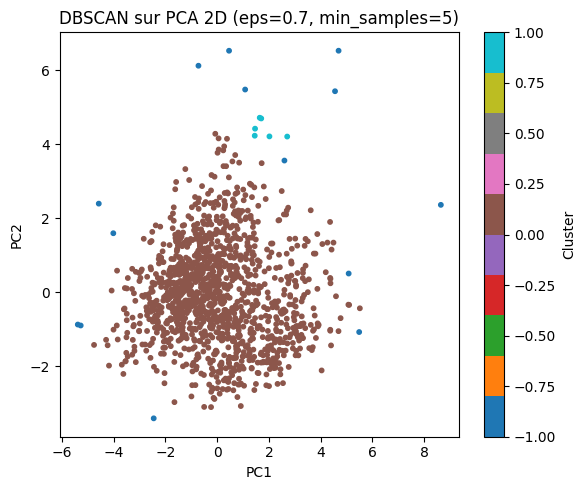

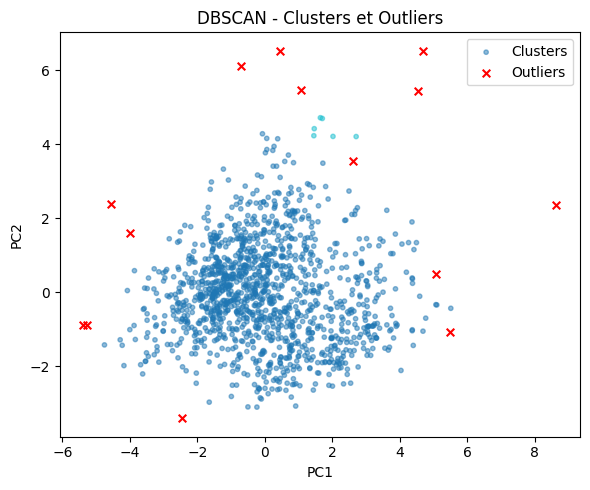

In [5]:
# Visualisation des clusters et outliers
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", s=10)
plt.colorbar(scatter, label="Cluster")
plt.title(f"DBSCAN sur PCA 2D (eps={eps}, min_samples={min_samples})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("dbscan_clusters.png")
plt.show()

# Visualisation séparée des outliers
outliers_mask = labels == -1
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[~outliers_mask, 0], X_pca[~outliers_mask, 1], c=labels[~outliers_mask], cmap="tab10", s=10, alpha=0.5, label="Clusters")
plt.scatter(X_pca[outliers_mask, 0], X_pca[outliers_mask, 1], c='red', s=30, marker='x', label="Outliers")
plt.title(f"DBSCAN - Clusters et Outliers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig("dbscan_outliers.png")
plt.show()

## 6. Comparaison avec les catégories de qualité

Répartition qualité par cluster (outliers = -1):
             mean       std  count
cluster                           
-1       5.285714  0.726273     14
 0       5.626587  0.823466   1339
 1       5.666667  1.032796      6


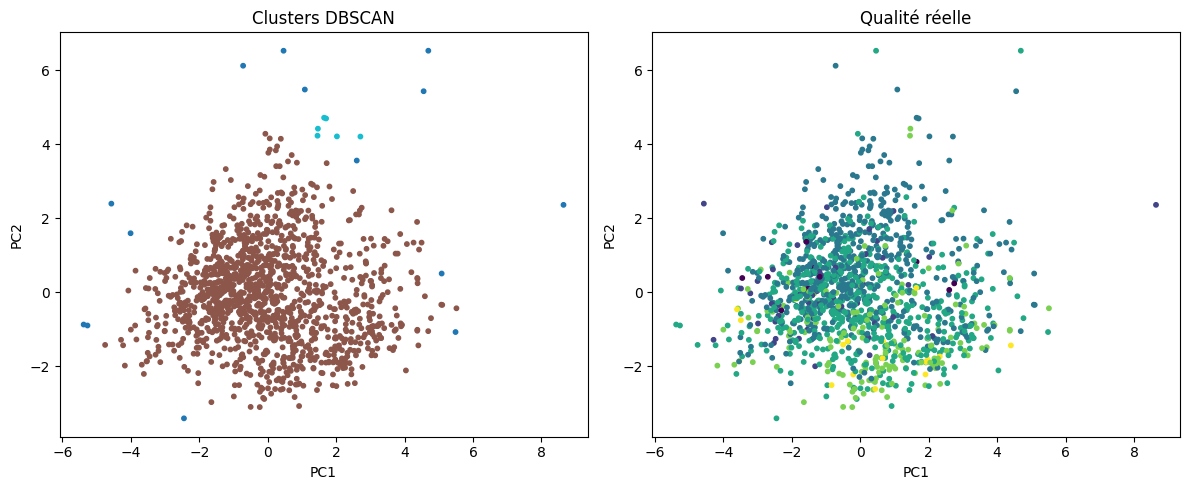

In [6]:
# Comparaison clusters vs qualité réelle
comparison_df = pd.DataFrame({
    'cluster': labels,
    'quality': y
})

print("Répartition qualité par cluster (outliers = -1):")
print(comparison_df.groupby('cluster')['quality'].agg(['mean', 'std', 'count']))

# Visualisation clusters vs quality
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", s=10)
axes[0].set_title(f"Clusters DBSCAN")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", s=10)
axes[1].set_title("Qualité réelle")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.savefig("dbscan_comparison.png")
_cwd = os.getcwd()
_project_root = os.path.dirname(_cwd) if os.path.basename(_cwd) in ('classification','clustering','reduction') else _cwd
_fig_dir = os.path.join(_project_root, 'rapport', 'figures')
os.makedirs(_fig_dir, exist_ok=True)
plt.savefig(os.path.join(_fig_dir, 'dbscan_comparison.png'))
plt.show()

## 7. MLflow tracking

In [7]:
with mlflow.start_run(run_name=f"DBSCAN_eps{eps}_min{min_samples}"):
    mlflow.log_param("eps", eps)
    mlflow.log_param("min_samples", min_samples)
    mlflow.log_metric("n_clusters", n_clusters)
    mlflow.log_metric("n_outliers", n_noise)
    
    if sil >= 0:
        mlflow.log_metric("silhouette_score", float(sil))
    
    mlflow.log_artifact("dbscan_clusters.png")
    mlflow.log_artifact("dbscan_outliers.png")
    mlflow.log_artifact("dbscan_comparison.png")
    mlflow.sklearn.log_model(dbscan, "dbscan_model")
    print("MLflow run terminé")

2026/02/14 17:35:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
2026/02/14 17:35:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


MLflow run terminé
